In [59]:
import sys
import os
import json
import glob
import h5py

import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('assets_psychophysics')
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

sys.path.append('assets_datasets')
import util_stimuli
importlib.reload(util_stimuli)

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'


In [2]:
IHC_cutoff = 3000.0
BW_scale_factor = 1.0
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[1e-1],
        'cohc':1.0,
        'bandwidth_scale_factor':BW_scale_factor,
        'IhcLowPass_cutoff': IHC_cutoff,
        'IhcLowPass_order': 7,
    },
}


sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 200
phase_mode = 'sine'

freq_list = f0*np.arange(1, 60)
if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))
for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)

snr = 10
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))

# fn = '/om/user/msaddler/data_pitchnet/oxenham2004/Oxenham2004_transposedTones_f0_080to320Hz/Oxenham2004_transposedTones_f0_080to320Hz.hdf5'
# f = h5py.File(fn, 'r')
# y = f['stimuli/signal'][3999]
# sr = f['sr'][0]
# f.close()

# fn = '/om/scratch/Wed/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_sr32000_v08_0000000-0021000.hdf5'
# f = h5py.File(fn, 'r')
# IDX = 14184#np.random.randint(f['stimuli/signal'].shape[0])
# signal = f['stimuli/signal'][IDX]
# noise = f['stimuli/noise'][IDX]
# f0 = f['nopad_f0_mean'][IDX]
# print(IDX, f0)
# sr = f['sr'][0]
# f.close()

snr = 10
dBSPL = 60

y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))

ipd.display(ipd.Audio(y, rate=sr))


In [3]:
out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)


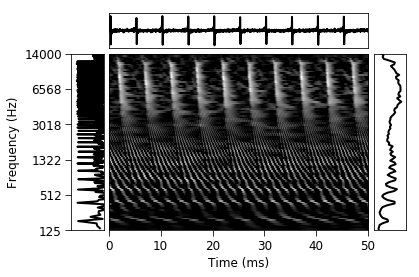

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_nervegram_with_waveform_200HzF0_IHC3000Hz_LSR_fibers.pdf


In [5]:
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

figsize=(6, 4)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.05,
    'hspace': 0.05,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 5],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)

util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
    ax_idx_nervegram=4,
    ax_idx_spectrum=3,
    ax_idx_excitation=5,
    ax_idx_waveform=1,
    nervegram=out_dict['meanrates'],
    nervegram_sr=out_dict['meanrates_fs'],
    waveform=out_dict['pin'],
    waveform_sr=out_dict['pin_fs'],
    cfs=out_dict['cf_list'],
    fontsize_title=12,
    fontsize_labels=12,
    fontsize_legend=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    plot_kwargs={'lw':2},
    limits_buffer=0.2,
    nxticks=6, 
    nyticks=6,
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    spines_to_hide_waveform=[])#['top', 'bottom', 'left', 'right'])

plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)

# save_fn = os.path.join(save_dir, 'tmp_nervegram_with_waveform_{:.0f}HzF0_IHC{:04.0f}Hz_LSR_fibers.pdf'.format(f0, IHC_cutoff))
# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)



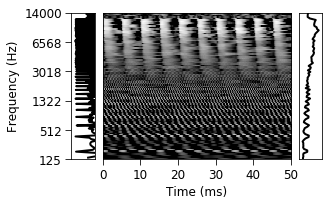

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_nervegram_200HzF0_IHC3000Hz_BW2xNarrower.pdf


In [55]:
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

figsize=(5*.9, 3*.9)
nrows=1
ncols=3
gridspec_kw = {
    'wspace': 0.1,
    'width_ratios': [1, 8, 1],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)

util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
    ax_idx_nervegram=1,
    ax_idx_spectrum=0,
    ax_idx_excitation=2,
    ax_idx_waveform=None,
    nervegram=out_dict['meanrates'],
    nervegram_sr=out_dict['meanrates_fs'],
    waveform=out_dict['pin'],
    waveform_sr=out_dict['pin_fs'],
    cfs=out_dict['cf_list'],
    fontsize_title=12,
    fontsize_labels=12,
    fontsize_legend=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    plot_kwargs={'lw':2},
    limits_buffer=0.2,
    nxticks=6, 
    nyticks=6,
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    spines_to_hide_waveform=[])#['top', 'bottom', 'left', 'right'])

plt.show()


# save_fn = os.path.join(save_dir, 'tmp_nervegram_{:.0f}HzF0_IHC{:04.0f}Hz_BW2xNarrower.pdf'.format(f0, IHC_cutoff))
# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


In [ ]:
figsize = (1.8, 0.6)
tmin = 0.075
tmax = 0.121
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=signal,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_signal.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=noise,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


figsize=(2.4, 1.6)
nrows=1
ncols=1
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
                                  ax_idx_nervegram=0,
                                  ax_idx_spectrum=None,
                                  ax_idx_excitation=None,
                                  ax_idx_waveform=None,
                                  nervegram=out_dict['meanrates'],
                                  nervegram_sr=out_dict['meanrates_fs'],
                                  waveform=out_dict['pin'],
                                  waveform_sr=out_dict['pin_fs'],
                                  cfs=out_dict['cf_list'],
                                  fontsize_title=12,
                                  fontsize_labels=12,
                                  fontsize_legend=12,
                                  fontsize_ticks=12,
                                  fontweight_labels=None,
                                  plot_kwargs={'lw':2},
                                  limits_buffer=0.2,
                                  nxticks=0, 
                                  nyticks=0,
                                  spines_to_hide_spectrum=[],
                                  spines_to_hide_excitation=[],
                                  spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])
ax_arr.set_xlabel(None)
ax_arr.set_ylabel(None)
plt.show()
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_signal_in_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


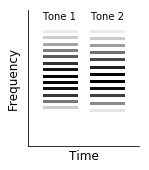

In [19]:
import stimuli_generate_BernsteinOxenhamFixedFilter
import matplotlib.cm


def map_level_to_color(level,
                       level_min=None,
                       level_max=None,
                       cmap_name='Greys',
                       cmap_n=None):
    '''
    '''
    level = np.array(level)
    if level_min is not None:
        level[level < level_min] = level_min
    if level_max is not None:
        level[level > level_max] = level_max
    level_normalized = level - np.min(level)
    level_normalized = level_normalized / np.max(level_normalized)
    cmap = matplotlib.cm.get_cmap(cmap_name, cmap_n)
    color = cmap(level_normalized)
    return color


def schematic_spectrogram(ax, times, freqs,
                          colors='k',
                          kwargs_plot_update={}):
    '''
    '''
    kwargs_plot = {
        'lw': 3,
        'ls': '-',
        'marker': '',
    }
    kwargs_plot.update(kwargs_plot_update)
    if not len(colors) == len(freqs):
        assert len(colors) == 1
        colors = [colors] * len(freqs)
    for f, c in zip(freqs, colors):
        kwargs_plot['color'] = c
        ax.plot(times, np.ones_like(times)*f, **kwargs_plot)
    return ax


fs = 32000
highpass_filter_cutoff = 2.5e3
lowpass_filter_cutoff = 3.5e3
filter_order = 4

base_f0 = 300
lh = 5
threshold_dBSPL=33.3
component_dBSL=15.0

baseline_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.get_bandpass_filter_frequency_response(
    highpass_filter_cutoff,
    lowpass_filter_cutoff,
    fs=fs, order=filter_order)
desired_fl = base_f0 * lh
desired_fl_gain_in_dB = -1 * component_dBSL
fixed_freq_response = stimuli_generate_BernsteinOxenhamFixedFilter.shift_bandpass_filter_frequency_response(
    desired_fl, desired_fl_gain_in_dB, fs=fs, unshifted_passband=None,
    frequency_response_in_dB=baseline_freq_response)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.0, 2.5))
level_min = -component_dBSL-1
dur = 1
gap = 0.5
times = np.array([0.0, dur])

for itr_f0, f0 in enumerate([base_f0 * 0.94, base_f0 * 1.06]):
    freqs = np.arange(f0, fs/2, f0)
    colors = map_level_to_color(fixed_freq_response(freqs), level_min=level_min)
    ax = schematic_spectrogram(ax, times, freqs, colors=colors)
    
    ax.text(np.mean(times), 19*base_f0, 'Tone {}'.format(itr_f0 + 1),
            ha='center',  va='center', fontsize=10)
    
    times = times + gap + dur

limits_buffer = 0.2
[xb, yb, dxb, dyb] = ax.dataLim.bounds
limits_x = [xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb]

ax = util_figures.format_axes(ax,
    str_xlabel='Time',
    str_ylabel='Frequency',
    fontsize_labels=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    xscale='linear',
    yscale='linear',
    xlimits=limits_x,
    ylimits=[0, 6000],
    xticks=[],
    yticks=np.arange(base_f0, 6000, base_f0),
    xticks_minor=None,
    yticks_minor=None,
    xticklabels=None,
    yticklabels=[],
    spines_to_hide=['right', 'top'],
    major_tick_params_kwargs_update={'length':0},
    minor_tick_params_kwargs_update={})

plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_stimulus_bernox_spectrogram.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


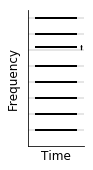

In [6]:
f0 = 100
fs = 32000
dur = 1.0

freqs = np.arange(1, 8+1) * f0
IDX = 5
IDX_base_f = freqs[IDX]
IDX_mistuned_f = IDX_base_f * 1.03
freqs[IDX] = IDX_mistuned_f

colors = ['k'] * len(freqs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 2.5))
times = np.array([0, dur])
ax = schematic_spectrogram(ax, times, freqs, colors=colors, kwargs_plot_update={'lw':2})


kwargs_arrow = {
    'x': dur * 1.15,
    'dx': 0,
    'dy': IDX_mistuned_f - IDX_base_f,
    'y': IDX_base_f,
    'width': 0.005,
    'length_includes_head': False,
    'head_width': 0.025,
    'head_length': (IDX_mistuned_f - IDX_base_f)/2,
    'overhang': 0.0,
    'head_starts_at_zero': False,
    'fc': 'k',
    'ec': 'k',
}
ax.arrow(**kwargs_arrow)

limits_buffer = 0.2
# ax.update_datalim([[x, y], [x+dx, y+dy]])
[xb, yb, dxb, dyb] = ax.dataLim.bounds
limits_x = [xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb]

ax = util_figures.format_axes(ax,
    str_xlabel='Time',
    str_ylabel='Frequency',
    fontsize_labels=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    xscale='linear',
    yscale='linear',
    xlimits=limits_x,
    ylimits=[0, freqs[-1] + f0/2],
    xticks=[],
    yticks=np.arange(f0, freqs[-1] + f0/2, f0),
    xticks_minor=None,
    yticks_minor=None,
    xticklabels=None,
    yticklabels=[],
    spines_to_hide=['right', 'top'],
    major_tick_params_kwargs_update={'length': 0},
    minor_tick_params_kwargs_update={})

ax.grid(linewidth=0.2, color='k')

plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_stimulus_mistuned_spectrogram.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


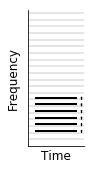

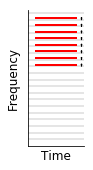

In [7]:
import stimuli_generate_FrequencyShiftedComplexes

list_spectral_envelope_params = [
    {'spectral_envelope_centered_harmonic': 5, 'spectral_envelope_bandwidth_in_harmonics': 3}, # "RES"
#     {'spectral_envelope_centered_harmonic': 11, 'spectral_envelope_bandwidth_in_harmonics': 5}, # "INT"
    {'spectral_envelope_centered_harmonic': 16, 'spectral_envelope_bandwidth_in_harmonics': 5}, # "UNRES"
]

list_colors = [
    'k',
#     'b',
    'r',
]

f0_shift = 0.24
f0 = 100
fs = 32000
dur = 1.0


for spectral_envelope_params, c in zip(list_spectral_envelope_params, list_colors):
    harmonic_centered = spectral_envelope_params['spectral_envelope_centered_harmonic']
    harmonic_bandwidth = spectral_envelope_params['spectral_envelope_bandwidth_in_harmonics']
    f_center = f0 * harmonic_centered
    f_bandwidth = f0 * harmonic_bandwidth
    spectral_envelope = stimuli_generate_FrequencyShiftedComplexes.get_MooreMoore2003_spectral_envelope(
        f0, f_center, f_bandwidth)
    
    frequencies = np.arange(f0, fs/2, f0, dtype=np.float32)
    frequencies = frequencies + f0*f0_shift
    amplitudes = spectral_envelope(frequencies)
    frequencies = frequencies[amplitudes > 0]
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.0, 2.5))
    times = np.array([0, dur])
    ax = schematic_spectrogram(ax, times, frequencies, colors=c, kwargs_plot_update={'lw':2})
    
    for f in frequencies:
        kwargs_arrow = {
            'x': dur * 1.15,
            'dx': 0,
            'dy': f0*f0_shift,
            'y': f - f0*f0_shift,
            'width': 0.005,
            'length_includes_head': False,
            'head_width': 0.025,
            'head_length': (f0*f0_shift)/2,
            'overhang': 0.0,
            'head_starts_at_zero': False,
            'fc': 'k',
            'ec': 'k',
        }
        ax.arrow(**kwargs_arrow)
    
    limits_buffer = 0.2
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    limits_x = [xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb]

    ax = util_figures.format_axes(ax,
        str_xlabel='Time',
        str_ylabel='Frequency',
        fontsize_labels=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        xscale='linear',
        yscale='linear',
        xlimits=limits_x,
        ylimits=[0, 20.5*f0],
        xticks=[],
        yticks=np.arange(f0, 20.5*f0, f0),
        xticks_minor=None,
        yticks_minor=None,
        xticklabels=None,
        yticklabels=[],
        spines_to_hide=['right', 'top'],
        major_tick_params_kwargs_update={'length': 0},
        minor_tick_params_kwargs_update={})

    ax.grid(linewidth=0.2, color='k')

    plt.show()

#     ch = spectral_envelope_params['spectral_envelope_centered_harmonic']
#     save_fn = os.path.join(save_dir, 'tmp_schematic_stimulus_freqshift_spectrogram_{}.pdf'.format(ch))
#     fig.savefig(save_fn, bbox_inches='tight')


In [ ]:
import stimuli_generate_TransposedTones

dict_stimuli = {
    'PT': {'f_carrier': 0.0, 'f_envelope': 200},
    'TT': {'f_carrier': 6350.0, 'f_envelope': 200},
}

for key in dict_stimuli.keys():
    sr = 32000
    f_carrier = dict_stimuli[key]['f_carrier']
    f_envelope = dict_stimuli[key]['f_envelope']
    y = stimuli_generate_TransposedTones.get_Oxenham2004_transposed_tone(
        f_carrier, f_envelope, fs=sr, dur=0.150, buffer_dur=1.0,
        dBSPL=70.0, offset_start=False, lowpass_filter_envelope=True)
    dict_stimuli[key]['out_dict'] = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)

f.close()

In [ ]:
for key in dict_stimuli.keys():
    out_dict = dict_stimuli[key]['out_dict']

    figsize=(1.8, 1.5)
    nrows=2
    ncols=1
    gridspec_kw = {
        'hspace': 0.1,
        'height_ratios': [1, 4],
    }
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
    ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
        ax_idx_nervegram=1,
        ax_idx_spectrum=None,
        ax_idx_excitation=None,
        ax_idx_waveform=0,
        nervegram=out_dict['meanrates'],
        nervegram_sr=out_dict['meanrates_fs'],
        waveform=out_dict['pin'],
        waveform_sr=out_dict['pin_fs'],
        tmin=tmin,
        tmax=tmax,
        cfs=out_dict['cf_list'],
        fontsize_title=12,
        fontsize_labels=12,
        fontsize_legend=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        plot_kwargs={},
        limits_buffer=0.2,
        nxticks=0, 
        nyticks=0,
        spines_to_hide_spectrum=[],
        spines_to_hide_excitation=[],
        spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Frequency')
    
    if dict_stimuli[key]['f_carrier'] == 0:
        ax[0].set_title('Pure tone')
    else:
        ax[0].set_title('Transposed tone')
    plt.show()
    
    save_fn = os.path.join(save_dir, 'tmp_schematic_stimulus_transposedtones_nervegram_{}.pdf'.format(key))
    fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


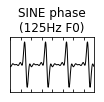

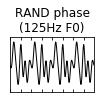

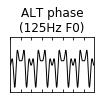

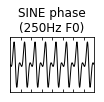

In [38]:
import stimuli_generate_AltPhaseHarmonics

np.random.seed(4078)

fs = 32000
dur = 0.150
f0 = 125
passband_component_dBSPL=50.0

list_filter_params = [
    {'fl': 125.0, 'fh': 625.0, 'fs': fs, 'order':8},
#     {'fl': 1375.0, 'fh': 1875.0, 'fs': fs, 'order':8},
#     {'fl': 3900.0, 'fh': 5400.0, 'fs': fs, 'order':8},
]
filter_params = list_filter_params[0]
frequency_response_in_dB = stimuli_generate_AltPhaseHarmonics.get_bandpass_filter_frequency_response(
    **filter_params)

base_f0 = 125
list_stimuli_dict = [
    {'phase_mode': 'sine', 'f0': base_f0},
    {'phase_mode': 'rand', 'f0': base_f0},
    {'phase_mode': 'alt', 'f0': base_f0},
    {'phase_mode': 'sine', 'f0': 2*base_f0},
]

for stimulis_dict in list_stimuli_dict:
    f0 = stimulis_dict['f0']
    phase_mode = stimulis_dict['phase_mode']
    harmonic_freqs = np.arange(f0, fs/2, f0)
    harmonic_numbers = harmonic_freqs / f0
    harmonic_dBSPL = passband_component_dBSPL + frequency_response_in_dB(harmonic_freqs)
    amplitudes = 20e-6 * np.power(10, (harmonic_dBSPL/20))
    y = util_stimuli.complex_tone(f0, sr, dur,
                                  harmonic_numbers=harmonic_numbers,
                                  amplitudes=amplitudes,
                                  phase_mode=phase_mode,
                                  offset_start=False)

    figsize=(1.5, 1.0)
    nrows=1
    ncols=1
    tmin = 0.01
    tmax = tmin + 4/base_f0
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
        ax_idx_nervegram=None,
        ax_idx_spectrum=None,
        ax_idx_excitation=None,
        ax_idx_waveform=0,
        nervegram=None,
        nervegram_sr=None,
        waveform=y,
        waveform_sr=sr,
        tmin=tmin,
        tmax=tmax,
        cfs=[],
        fontsize_title=12,
        fontsize_labels=12,
        fontsize_legend=12,
        fontsize_ticks=12,
        fontweight_labels=None,
        plot_kwargs={'lw':1.0},
        limits_buffer=0.2,
        nxticks=0, 
        nyticks=0,
        spines_to_hide_waveform=[],
        spines_to_hide_spectrum=[],
        spines_to_hide_excitation=[])
    ax[0].set_title('{} phase\n({:.0f}Hz F0)'.format(phase_mode.upper(), f0))
    ax[0].set_xticks(np.arange(0, tmax-tmin, 1/(2*base_f0)))
    major_tick_params_kwargs = {
        'axis': 'both',
        'which': 'major',
        'length': 3,
        'direction': 'in',
        'top': True,
        'bottom': True,
    }
    ax[0].tick_params(**major_tick_params_kwargs)
    plt.show()
    
    save_fn = os.path.join(save_dir, 'tmp_schematic_stimulus_waveform_{}phase_{:.0f}f0.pdf'.format(phase_mode.upper(), f0))
    fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


In [22]:
import os
import sys
import json
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker

sys.path.append('assets_datasets/')
sys.path.append('assets_psychophysics/')
import util_figures
import stimuli_f0_labels
import f0dl_bernox

regex_model_dir = '/nobackup/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_0302/'
model_dir = glob.glob(regex_model_dir)[0]
fn_valid = os.path.join(model_dir, 'EVAL_validation_bestckpt.json')

f0_label_true_key = 'f0_label:labels_true'
f0_label_pred_key = 'f0_label:labels_pred'
kwargs_f0_bins = {}

expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(fn_valid,
                                                    metadata_key_list=[],
                                                    f0_label_true_key=f0_label_true_key,
                                                    f0_label_pred_key=f0_label_pred_key)
expt_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(expt_dict,
                                                      f0_label_true_key=f0_label_true_key,
                                                      f0_label_pred_key=f0_label_pred_key)
f0_bins = stimuli_f0_labels.get_f0_bins(**kwargs_f0_bins)
f0_label_true = expt_dict[f0_label_true_key]
f0_label_pred = expt_dict[f0_label_pred_key]
    
confusion_matrix = np.zeros([f0_bins.shape[0], f0_bins.shape[0]])
confusion_matrix_counts = np.zeros_like(confusion_matrix)

for t, p in zip(f0_label_true, f0_label_pred):
    confusion_matrix[p, t] += 1
    confusion_matrix_counts[:, t] += 1

confusion_matrix = confusion_matrix / confusion_matrix_counts


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


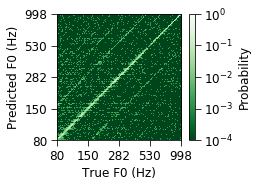

In [50]:
fontsize_title = 12
fontsize_labels = 12
fontsize_legend = 12
fontsize_ticks = 12
figsize = (4*.9, 3*.9)
nticks = 5

tmp_confusion_matrix = confusion_matrix.copy()
floor_val = -4
tmp_confusion_matrix = np.log10(tmp_confusion_matrix)
tmp_confusion_matrix[tmp_confusion_matrix < floor_val] = floor_val

vmin = floor_val #np.min(np.min(tmp_confusion_matrix))
vmax = 0 #np.max(np.max(tmp_confusion_matrix))
vticks = np.linspace(vmin, vmax, nticks)
vticklabels = [r'$10^{{{:.0f}}}$'.format(v) for v in vticks]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
cmap = ax.imshow(tmp_confusion_matrix, origin='lower', aspect='auto',
                 extent=[0, tmp_confusion_matrix.shape[1], 0, tmp_confusion_matrix.shape[0]],
                 cmap='Greens_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(cmap, ax=ax, pad=0.05)
cbar.ax.set_ylabel('Probability', fontsize=fontsize_labels)
cbar.set_ticks(vticks)
cbar.set_ticklabels(vticklabels)
# cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.tick_params(direction='out',
                    axis='both',
                    which='both',
                    labelsize=fontsize_ticks,
                    length=fontsize_ticks/2)

xticks = np.linspace(0, f0_bins.shape[0]-1, nticks).astype(int)
xticklabels = ['{:.0f}'.format(t) for t in f0_bins[xticks]]

ax = util_figures.format_axes(ax,
                              str_xlabel='True F0 (Hz)',
                              str_ylabel='Predicted F0 (Hz)',
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='linear',
                              yscale='linear',
                              xlimits=None,
                              ylimits=None,
                              xticks=xticks,
                              yticks=xticks,
                              xticks_minor=None,
                              yticks_minor=None,
                              xticklabels=xticklabels,
                              yticklabels=xticklabels,
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})

plt.tight_layout()
plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_confusion_matrix_arch0302.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


In [23]:
import os
import sys
import json
import glob
import copy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

valid_regex_format = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04d}/validation_metrics.json'


def get_valid_trace(valid_metrics_fn, metric_key='f0_label:accuracy', checkpoint_number_key='step'):
    '''
    '''
    with open(valid_metrics_fn) as f:
        valid_metrics_dict = json.load(f)
    metric_values = np.array(valid_metrics_dict[metric_key])
    checkpoint_numbers = np.array(valid_metrics_dict[checkpoint_number_key])
    return checkpoint_numbers, metric_values


list_arch_nums = []
list_traces = []
list_best_metric = []

for idx in range(750):
    valid_metrics_fn_list = glob.glob(valid_regex_format.format(idx))
    if len(valid_metrics_fn_list) > 0:
        valid_metrics_fn = valid_metrics_fn_list[0]
        checkpoint_numbers, metric_values = get_valid_trace(valid_metrics_fn)
        list_arch_nums.append(idx)
        list_traces.append((checkpoint_numbers, metric_values))
        list_best_metric.append(np.max(metric_values))

print(len(list_arch_nums))


392


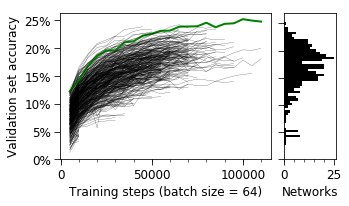

In [91]:
fontsize_title = 12
fontsize_labels = 12
fontsize_legend = 12
fontsize_ticks = 12
figsize = (5.5*.9, 3*.9)

kwargs_plot = {
    'marker': '',
    'lw': 0.2,
    'color': [0] * 3
}
kwargs_plot_accent = copy.deepcopy(kwargs_plot)
kwargs_plot_accent['color'] = 'g'
kwargs_plot_accent['lw'] = 2
accent_arch_num = 302
batch_size = 64

gridspec_kw = {
    'wspace': 0.1,
    'width_ratios': [4, 1],
}
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax_arr[0]

max_steps = 0
for arch_num, (checkpoint_numbers, metric_values) in zip(list_arch_nums, list_traces):
    max_steps = max(max_steps, max(checkpoint_numbers))
    if arch_num == accent_arch_num:
        ax.plot(checkpoint_numbers, 100*metric_values, **kwargs_plot_accent)
    else:
        ax.plot(checkpoint_numbers, 100*metric_values, **kwargs_plot)

xlimits = [0, (max_steps + 10000)]
xticks = np.arange(xlimits[0], xlimits[-1], 50000)
xticks_minor = np.arange(xlimits[0], xlimits[-1], 10000)
xticklabels = ['{:.0f}'.format(t) for t in xticks]
ylimits = [0, 27]
yticks = np.arange(ylimits[0], ylimits[-1], 5)
yticklabels = ['{:.0f}%'.format(t) for t in yticks]

ax = util_figures.format_axes(ax,
                              str_xlabel='Training steps (batch size = {})'.format(batch_size),
                              str_ylabel='Validation set accuracy',
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='linear',
                              yscale='linear',
                              xlimits=None,
                              ylimits=None,
                              xticks=xticks,
                              yticks=yticks,
                              xticks_minor=xticks_minor,
                              yticks_minor=None,
                              xticklabels=xticklabels,
                              yticklabels=yticklabels,
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})

ax = ax_arr[1]

bin_counts, bin_edges = np.histogram(100*np.array(list_best_metric), bins=50)
bin_widths = np.diff(bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax.barh(bin_centers, bin_counts, height=bin_widths, align='center', color=kwargs_plot['color'])
ax = util_figures.format_axes(ax,
                              str_xlabel='Networks'.format(batch_size),
                              str_ylabel=None,
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='linear',
                              yscale='linear',
                              xlimits=None,
                              ylimits=ylimits,
                              xticks=[0, 25],
                              yticks=yticks,
                              xticks_minor=np.arange(0, 25, 5),
                              yticks_minor=None,
                              xticklabels=None,
                              yticklabels=[],
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})
plt.show()

save_fn = os.path.join(save_dir, 'tmp_schematic_valid_traces_arch_search_v01.pdf')
fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


In [76]:
import sys
import os
import json
import numpy as np
import glob

%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib.cm

import importlib
sys.path.append('assets_psychophysics')
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)


master_list = [
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Speech + Music (natural)', [0.0, 0.0, 0.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10_filter_signalBPv00/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Speech + Music (bandpass)', [0.0, 0.0, 1.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10_filter_signalHPv00/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Speech + Music (highpass)', [1.0, 0.0, 0.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_noise.json', 'Natural background noise', [0.6]*3),
    
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08spch/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Speech only', np.array([102,194,165])/256),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08inst/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Music only', np.array([252,141,98])/256),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_noise.json', 'Natural background noise', [0.6]*3),

#     ('/om/scratch/*/msaddler/data_pitchnet/PND_synthetic/noise_UMNm_snr_neg10pos10_phase01_filter_signalLPv00/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Synthetic tones (lowpass)', [0.0, 0.0, 0.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_synthetic/noise_UMNm_snr_neg10pos10_phase01_filter_signalBPv00/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Synthetic tones (bandpass)', [0.0, 0.0, 1.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_synthetic/noise_UMNm_snr_neg10pos10_phase01_filter_signalHPv00/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Synthetic tones (highpass)', [1.0, 0.0, 0.0]),
#     ('/om/scratch/*/msaddler/data_pitchnet/PND_synthetic/noise_UMNm_snr_neg10pos10_phase01_filter_signalHPv00/TMP_mean_spectrum_KEY_stimuli_noise.json', 'Synthetic background noise', [0.6]*3),

    ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_signal.json', 'Speech + Music', [0.0, 0.0, 0.0]),
    ('/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/TMP_mean_spectrum_KEY_stimuli_noise.json', 'Natural background noise', [0.6]*3),
]

list_data_dict = []
for (fn_regex, label, color) in master_list:
    fn = glob.glob(fn_regex)[0]
    with open(fn, 'r') as f:
        results_dict = json.load(f)
    data_dict = {
        'freqs': np.array(results_dict['freqs']),
        'mean_spectrum': np.array(results_dict['mean_spectrum']),
        'kwargs_plot': {
            'label': label,
            'color': color,
        },
        'is_noise': 'noise' in label.lower(),
    }
    list_data_dict.append(data_dict)

print(len(list_data_dict))


2


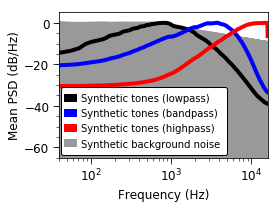

In [75]:
fontsize_title = 12
fontsize_labels = 12
fontsize_legend = 10
fontsize_ticks = 12
figsize = (4, 3)
nticks = 5

kwargs_plot = {
    'lw': 4,
    'marker': '',
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

for data_dict in list_data_dict:
    xvals = data_dict['freqs']
    yvals = data_dict['mean_spectrum']
    kwargs_plot.update(data_dict['kwargs_plot'])
    if data_dict['is_noise']:
        yvals = yvals - yvals.max()
        ax.plot(xvals, yvals, **kwargs_plot, zorder=-1)
        ax.fill_between(xvals, -100*np.ones_like(xvals), yvals,
                        color=kwargs_plot['color'],
                        alpha=1.0,
                        zorder=-1)
    else:
        yvals = yvals - yvals.max()
        ax.plot(xvals, yvals, **kwargs_plot)

xlimits = [40, 16000]
ylimits = [-65, 5]
yticks = np.arange(ylimits[0]+5, ylimits[-1], 20)
yticks_minor = np.arange(ylimits[0], ylimits[-1], 5)

ax = util_figures.format_axes(ax,
                              str_xlabel='Frequency (Hz)',
                              str_ylabel='Mean PSD (dB/Hz)',
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='log',
                              yscale='linear',
                              xlimits=xlimits,
                              ylimits=ylimits,
                              xticks=None,
                              yticks=yticks,
                              xticks_minor=None,
                              yticks_minor=yticks_minor,
                              xticklabels=None,
                              yticklabels=None,
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})

kwargs_legend = {
    'loc': 'lower left',
    'frameon': True,
    'framealpha': 1.0,
    'facecolor': 'w',
    'edgecolor': 'k',
    'handlelength': 0.5,
    'markerscale': 0.0,
    'fontsize': fontsize_legend,
    'borderpad': 0.65,
    'borderaxespad': 0.25,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

plt.tight_layout()
plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_mean_spectra_natural.pdf')
# save_fn = os.path.join(save_dir, 'tmp_schematic_mean_spectra_synthetic.pdf')
# save_fn = os.path.join(save_dir, 'tmp_schematic_mean_spectra_speech_vs_music.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


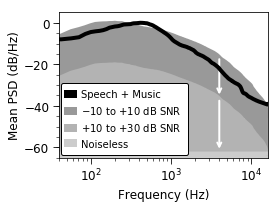

In [82]:
fontsize_title = 12
fontsize_labels = 12
fontsize_legend = 10
fontsize_ticks = 12
figsize = (4, 3)
nticks = 5

kwargs_plot = {
    'lw': 4,
    'marker': '',
}

assert len(list_data_dict) == 2, "ONLY SIGNAL + NOISE SUPPORTED"
data_dict_signal, data_dict_noise = list_data_dict
assert data_dict_noise['is_noise'], "NOISE DATA DICT MUST BE NOISE"

list_mean_snr = [0, 20, np.inf]
list_color = [
    [0.6]*3,
    [0.7]*3,
    [0.8]*3,
]
list_label = [
    '$-10$ to $+10$ dB SNR',
    '$+10$ to $+30$ dB SNR',
    'Noiseless'
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
xlimits = [40, 16000]
ylimits = [-65, 5]
minusinf_val = ylimits[0] + 2
yticks = np.arange(ylimits[0]+5, ylimits[-1], 20)
yticks_minor = np.arange(ylimits[0], ylimits[-1], 5)

xvals = data_dict_signal['freqs']
yvals = data_dict_signal['mean_spectrum']
kwargs_plot.update(data_dict_signal['kwargs_plot'])
yvals = yvals - yvals.max()
ax.plot(xvals, yvals, **kwargs_plot, zorder=10)

for idx in range(len(list_mean_snr)):
    mean_snr = list_mean_snr[idx]
    color = list_color[idx]
    label = list_label[idx]
    xvals = data_dict_noise['freqs']
    yvals = data_dict_noise['mean_spectrum']
    kwargs_plot.update({'color': color, 'label': label})
    yvals = yvals - yvals.max() - mean_snr
     
    yvals[yvals < minusinf_val] = minusinf_val
    ax.plot(xvals, yvals, **kwargs_plot, zorder=-1)
    
    if idx < len(list_mean_snr) - 1:
        next_yvals = yvals - (list_mean_snr[idx+1] - list_mean_snr[idx])
        next_yvals[next_yvals < minusinf_val] = minusinf_val
        IDX = np.argmin(np.abs(xvals-4000))
        dy = 0.95 * (next_yvals[IDX] - yvals[IDX])
        y = yvals[IDX]
        dx = 0
        x = xvals[IDX]
        draw_arrow = True
    else:
        next_yvals = ylimits[0] * np.ones_like(yvals)
        draw_arrow = False
    if draw_arrow:
        ax.annotate("",
                    xy=(x+dx, y+dy),
                    xytext=(x, y),
                    arrowprops=dict(arrowstyle="->", color='w', lw=2))
    
    ax.fill_between(xvals, yvals, next_yvals,
                    color=kwargs_plot['color'],
                    alpha=1.0,
                    zorder=-10)


ax = util_figures.format_axes(ax,
                              str_xlabel='Frequency (Hz)',
                              str_ylabel='Mean PSD (dB/Hz)',
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='log',
                              yscale='linear',
                              xlimits=xlimits,
                              ylimits=ylimits,
                              xticks=None,
                              yticks=yticks,
                              xticks_minor=None,
                              yticks_minor=yticks_minor,
                              xticklabels=None,
                              yticklabels=None,
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})

kwargs_legend = {
    'loc': 'lower left',
    'frameon': True,
    'framealpha': 1.0,
    'facecolor': 'w',
    'edgecolor': 'k',
    'handlelength': 0.5,
    'markerscale': 0.0,
    'fontsize': fontsize_legend,
    'borderpad': 0.65,
    'borderaxespad': 0.25,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

plt.tight_layout()
plt.show()

# save_fn = os.path.join(save_dir, 'tmp_schematic_mean_spectra_snr_manipulation.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


In [7]:
# Make nervegram image for CNN drawing

kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[70.0],
        'cohc':1.0,
        'bandwidth_scale_factor':1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}

fn = '/om/scratch/Fri/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_sr32000_v08_0000000-0021000.hdf5'
f = h5py.File(fn, 'r')
IDX = 14184#np.random.randint(f['stimuli/signal'].shape[0])
signal = f['stimuli/signal'][IDX]
noise = f['stimuli/noise'][IDX]
f0 = f['nopad_f0_mean'][IDX]
sr = f['sr'][0]
f.close()

snr = 10
dBSPL = 60

y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))

out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)
print(IDX, f0)


14184 207.65234


302


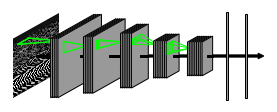

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0302.pdf
185


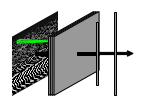

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0185.pdf
349


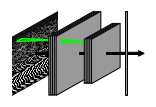

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0349.pdf
76


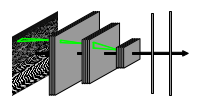

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0076.pdf
244


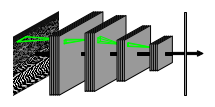

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0244.pdf
340


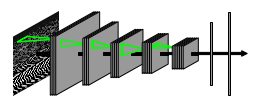

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0340.pdf
277


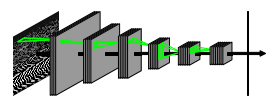

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0277.pdf
307


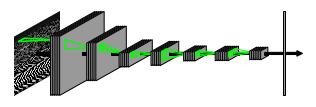

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0307.pdf
289


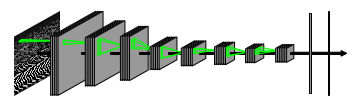

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/tmp_schematic_cnn_0289.pdf


In [10]:
# CNN drawing

import os
import sys
import json
import copy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import importlib
sys.path.append('assets_psychophysics')
import util_figures_cnn
importlib.reload(util_figures_cnn)


# brain_arch_fn = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_{:04.0f}/brain_arch.json'
# for ARCH_N in [0, 9, 19, 29]:
brain_arch_fn = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04.0f}/brain_arch.json'
# for ARCH_N in [302] + np.random.randint(0, 302, 20).tolist():
# for ARCH_N in [280, 373, 286, 208, 302, 291, 346, 259]:
for ARCH_N in [302] + [185, 349, 76, 244, 340, 277, 307, 289]:
    print(ARCH_N)
    layer_list = util_figures_cnn.process_cnn_layer_list(brain_arch_fn.format(ARCH_N))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
    ax = util_figures_cnn.draw_cnn_from_layer_list(ax, layer_list,
                                                   deg_scale_x=60,
                                                   deg_skew_y=30,
                                                   scaling_w='log2',
                                                   scaling_h='log2',
                                                   scaling_n='log2',
                                                   input_image=np.squeeze(out_dict['meanrates']))
    
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    fig_factor = 6
    fig.set_size_inches(dxb/fig_factor, dyb/fig_factor)
    
    plt.show()
    
#     save_fn = os.path.join(save_dir, 'tmp_schematic_cnn_{:04d}.pdf'.format(ARCH_N))
#     fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)
#     print(save_fn)
